# Set up and test connect

## Remote Spark Kernel via Jupyter Enterprise Gateway

In [1]:
from pyspark.sql import SparkSession
import pandas as pd

spark = (
    SparkSession.builder
    .appName("VNStock")
    .master("spark://spark-master:7077")  
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000")
    .getOrCreate()
)

print("Spark connected:", spark.version)


Spark connected: 3.5.0


# Test get data

## Get all stock code

In [2]:
symbols = spark.read.csv("hdfs://namenode:9000/data/symbol.txt")

In [3]:
symbols = symbols.toPandas()

In [4]:
symbols.head()

,_c0
0,VCB
1,BID\t
2,CTG\t
3,TCB\t
4,MBB


## Get data of stock code

In [5]:
mbb = spark.read.csv("hdfs://namenode:9000/data/MBB.csv", header=True, inferSchema=True)
MBB = mbb.toPandas()
MBB.head() 

,time,open,high,low,close,volume
0,2015-01-05,2.31,2.31,2.29,2.29,338650
1,2015-01-06,2.29,2.38,2.29,2.36,2865710
2,2015-01-07,2.38,2.43,2.36,2.38,2235000
3,2015-01-08,2.38,2.43,2.38,2.40,853040
4,2015-01-09,2.40,2.54,2.40,2.52,6690100


# Preprocessing

## Normalize symbols

In [6]:
import re
def clean(code):
    clean_code = re.sub(r"\t", " ",code)
    clean_code = clean_code.upper()
    return clean_code.strip()

symbols_list = symbols._c0.apply(clean)

In [7]:
symbols_list

0    VCB
1    BID
2    CTG
3    TCB
4    MBB
5    ACB
6    VPB
7    HDB
8    STB
9    SHB
Name: _c0, dtype: object

## Convert to pandas for analysis easily

In [8]:
data = {}

for c in symbols_list:
    data[c] = spark.read.csv(f"hdfs://namenode:9000/data/{c}.csv", header=True, inferSchema=True).toPandas()
    data[c]['time'] = pd.to_datetime(data[c]['time']) # Conver to datatimetype

In [9]:
data['MBB']

,time,open,high,low,close,volume
0,2015-01-05,2.31,2.31,2.29,2.29,338650
1,2015-01-06,2.29,2.38,2.29,2.36,2865710
2,2015-01-07,2.38,2.43,2.36,2.38,2235000
3,2015-01-08,2.38,2.43,2.38,2.40,853040
4,2015-01-09,2.40,2.54,2.40,2.52,6690100
...,...,...,...,...,...,...
2494,2024-12-25,15.63,16.19,15.63,15.96,14826477
2495,2024-12-26,15.99,16.25,15.96,16.25,19914942
2496,2024-12-27,16.35,16.51,16.32,16.35,16712626
2497,2024-12-30,16.42,16.42,16.19,16.19,11072609


# Data Analysis

## Price trend

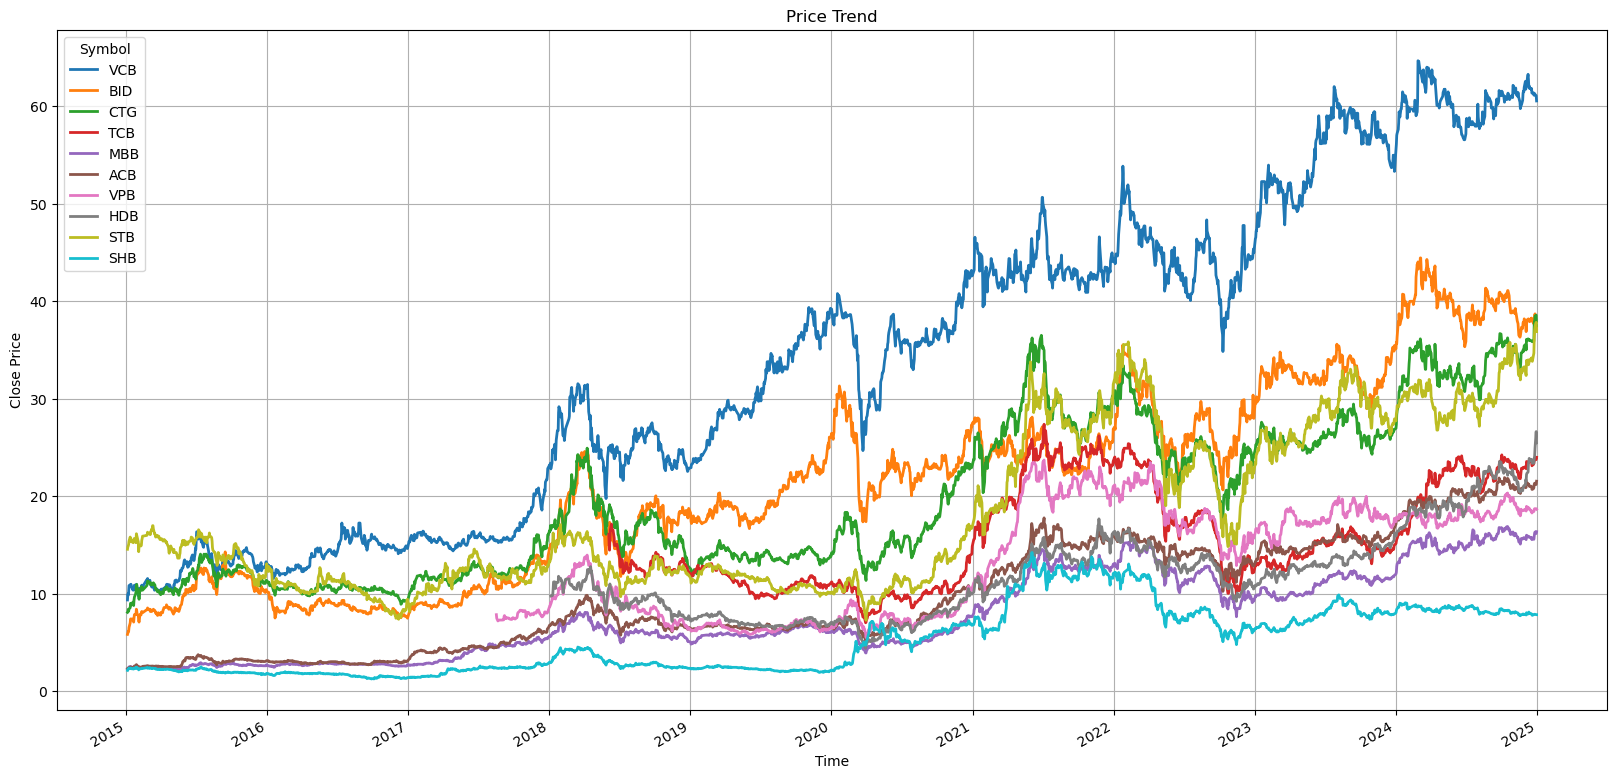

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))

for c in symbols_list:
    if c in data:
        data[c].plot(ax=ax, x='time', y='close', label=c, linewidth=2)
    else:
        print(f"Not found {c}")

ax.set_title('Price Trend')
ax.set_xlabel('Time')
ax.set_ylabel('Close Price')
ax.grid(True)
ax.legend(title="Symbol")
plt.show()

## Price growth rate

### EQUATION: Close_t - Close_0 / Close_0 * 100 %

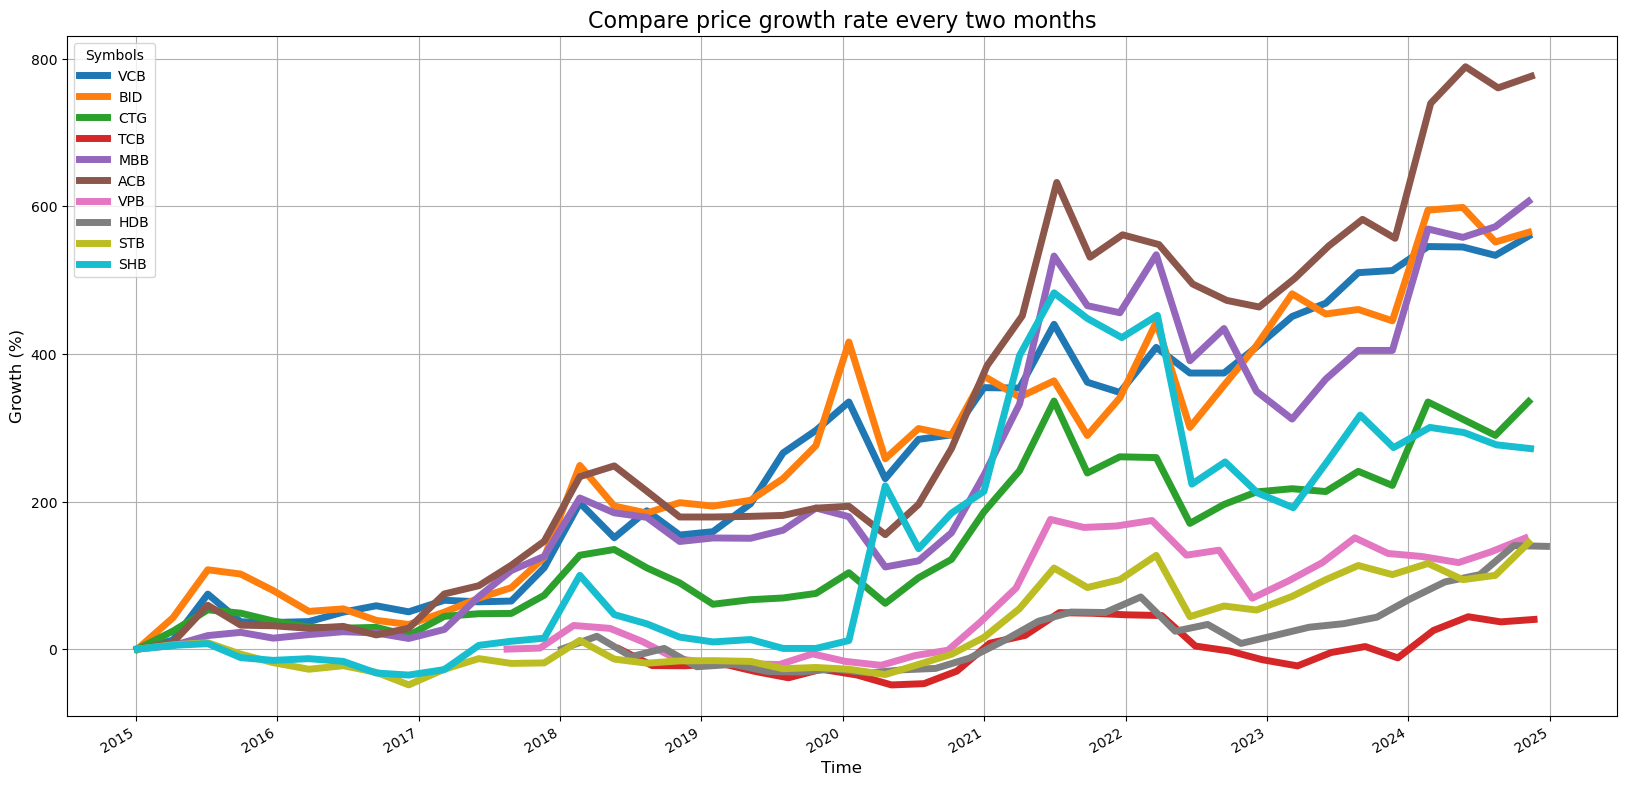

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
for c in symbols_list:
    if c in data:
        df = data[c].loc[::60].copy() # slice of 60 days to easily observation
        start_price = df['close'].iloc[0]
        df['returns'] = ((df['close'] - start_price) / start_price) * 100

        df.plot(ax=ax, x='time', y='returns', label=c, linewidth=5)
    else:
        print(f"Not found {c}")

ax.set_title('Compare price growth rate every two months', fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Growth (%)', fontsize=12)
ax.legend(title='Symbols', fontsize=10)
ax.grid()
plt.show()


# Prediction

We will use VCB's close price data to carry out this prediction task

In [12]:
code_used = "VCB"

VCB_dataset = data[code_used]
VCB_dataset.head()

,time,open,high,low,close,volume
0,2015-01-05,9.32,9.43,9.23,9.38,310010
1,2015-01-06,9.38,9.99,9.38,9.99,1684600
2,2015-01-07,10.02,10.17,9.73,9.88,1430340
3,2015-01-08,9.90,10.29,9.88,10.17,904240
4,2015-01-09,10.26,10.87,10.26,10.85,2286680


In [13]:
!pip install numpy==1.26.4 --force-reinstall
import numpy as np

if not hasattr(np, 'bool'):
    np.bool = np.bool_

!pip install --upgrade tensorflow

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata (62 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_aarch64.manylinux2014_aarch64.whl (14.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.


/tmp/ipykernel_3912/3805050827.py:4: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'bool'):


In [14]:
!pip show tensorflow | grep Version
!pip show numpy | grep Version

Version: 2.20.0
Version: 1.26.4
Version 3.1, 31 March 2009
                       Version 3, 29 June 2007
  5. Conveying Modified Source Versions.
  14. Revised Versions of this License.


In [15]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [25]:
lookback = 60

# Lưu mảng giá và ngày
data = VCB_dataset[['time', 'close']]
scaled_close = scaler.fit_transform(data[['close']])

dates = data['time'].values  # mảng ngày

X, y, dates_y = [], [], []  # thêm mảng ngày y

for i in range(lookback, len(scaled_close)):
    X.append(scaled_close[i-lookback:i, 0])
    y.append(scaled_close[i, 0])
    dates_y.append(dates[i])  # ngày tương ứng với giá trị y (ngày cần dự đoán)

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [23]:
X.shape

(2439, 60, 1)

In [18]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0214
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0034
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0029
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0025
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0022
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0018
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0019
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0019
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0018
Epoch 10/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0016
Epoch 11/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0013
Epoch 12/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0013
Epoch 13/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0014
Epoch 14/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0012
Epoch 15/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0012
Epoc

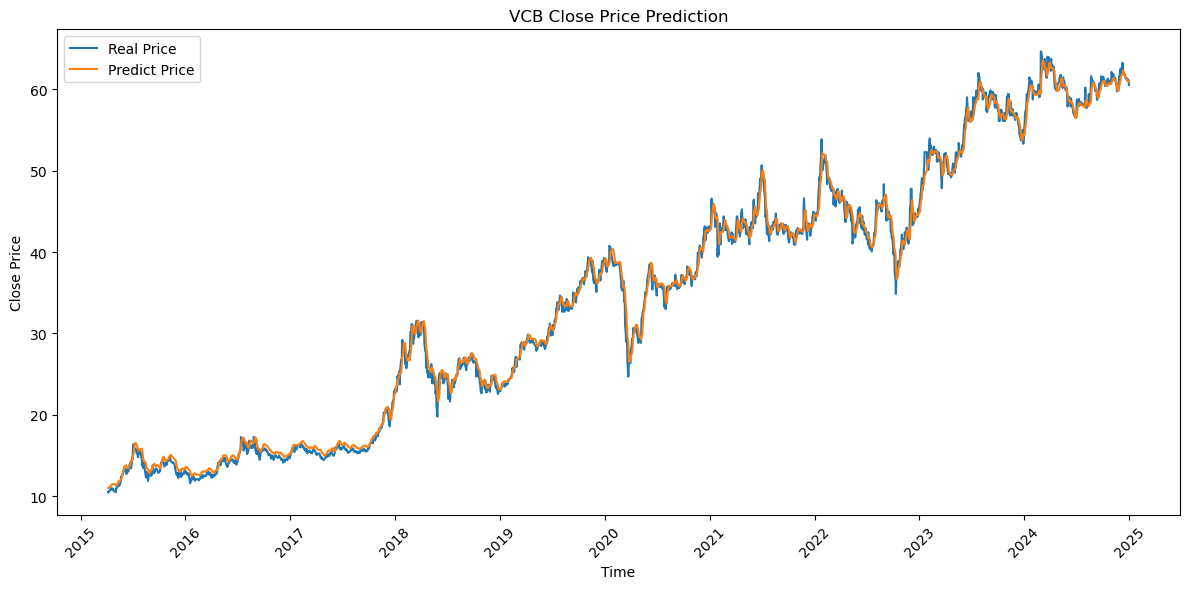

In [29]:
plt.figure(figsize=(12,6))
plt.plot(dates_y, real, label='Real Price')
plt.plot(dates_y, predictions, label='Predict Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('VCB Close Price Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(real, predictions)
mse = mean_squared_error(real, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(real, predictions)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


MAE: 0.6710
RMSE: 0.9080
R²: 0.9968
